# Two-Dimensional Lattice Examples

In [1]:
using Base.Filesystem
using Combinatorics
using CSV
using DataFrames
using FreeBird
using Plots
using Unitful

# Global variables
kB = 8.617333262e-5  # eV/K

8.617333262e-5

In [2]:
function plot_lattice(lattice::LatticeSystem, title::String)
    plot_lattice = plot(title=title, legend=false, aspect_ratio=:equal)
    num_positions = size(lattice.positions, 1)
    
    for index in 1:num_positions
        x, y = lattice.positions[index, :]
        scatter!(plot_lattice, [x], [y], color=:blue, markersize=10)
        annotate!(plot_lattice, x, y, text(index, 10, :white))
    end
    
    return plot_lattice
end

function print_lattice_info(lattice::LatticeSystem)
    println("LatticeSystem Information:")
    println("Supercell Dimensions: ", lattice.supercell_dimensions)
    println("Lattice Vectors:")
    println(lattice.lattice_vectors)
    println("Positions:")
    for i in 1:size(lattice.positions, 1)
        println("  Atom $i: (", lattice.positions[i, 1], ", ", lattice.positions[i, 2], ")")
    end
    println("Occupations: ", lattice.occupations)
    println("Neighbors:")
    for i in 1:length(lattice.neighbors)
        first_neighbors, second_neighbors = lattice.neighbors[i]
        println("  Atom $i: First Neighbors - ", first_neighbors, ", Second Neighbors - ", second_neighbors)
    end
end

print_lattice_info (generic function with 1 method)

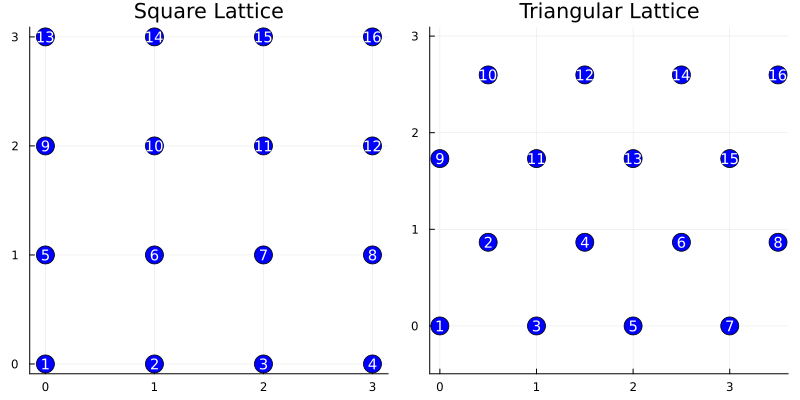

In [3]:
# Define a square lattice
square_lattice_constant = 1.0
square_primitive_lattice_vectors = [square_lattice_constant 0.0 0.0; 0.0 square_lattice_constant 0.0; 0.0 0.0 1.0]
square_basis = [(0.0, 0.0, 0.0)]
square_supercell_dimensions = (4, 4, 1)
square_periodicity = (true, true, false)
square_occupations = [true for i in 1:square_supercell_dimensions[1]*square_supercell_dimensions[2]*length(square_basis)]
square_adsorptions = [true for i in 1:square_supercell_dimensions[1]*square_supercell_dimensions[2]*length(square_basis)]
square_cutoff_radii = (1.1, 1.5)
square_lattice = LatticeSystem(
    square_primitive_lattice_vectors,
    square_basis,
    square_supercell_dimensions,
    square_periodicity,
    square_occupations,
    square_adsorptions,
    square_cutoff_radii
)
# print_lattice_info(square_lattice)

# Define a triangular Lattice
triangular_lattice_constant = 1.0
triangular_primitive_lattice_vectors = [triangular_lattice_constant 0.0 0.0; 0.0 sqrt(3) * triangular_lattice_constant 0.0; 0.0 0.0 1.0]
triangular_basis = [(0.0, 0.0, 0.0), (1/2, sqrt(3)/2, 0.0)]
triangular_supercell_dimensions = (4, 2, 1)
triangular_periodicity = (true, true, false)
triangular_occupations = [true for i in 1:triangular_supercell_dimensions[1]*triangular_supercell_dimensions[2]*length(triangular_basis)]
triangular_adsorptions = [true for i in 1:triangular_supercell_dimensions[1]*triangular_supercell_dimensions[2]*length(triangular_basis)]
triangular_cutoff_radii = (1.1, 1.1)
triangular_lattice = LatticeSystem(
    triangular_primitive_lattice_vectors,
    triangular_basis,
    triangular_supercell_dimensions,
    triangular_periodicity,
    triangular_occupations,
    triangular_adsorptions,
    triangular_cutoff_radii
)
# print_lattice_info(triangular_lattice)

# Plot the lattice
plot_square = plot_lattice(square_lattice, "Square Lattice")
plot_triangular = plot_lattice(triangular_lattice, "Triangular Lattice")
plot(plot_square, plot_triangular, layout=(1, 2), size=(800, 400))

## Square Lattice

In [4]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for exact enumeration
L = square_supercell_dimensions[1]  # Number of unit cells in x-direction
M = square_supercell_dimensions[2]  # Number of unit cells in y-direction
adsorption_energy = -0.04  # eV
nn_energy = -0.01  # eV
nnn_energy = -0.0025  # eV
cutoff_radii = (1.1, 1.5)  # Angstrom

# Define file paths for data
parameters = "exact_square_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"
microstates_file = "data/microstates_$parameters.csv"

# Perform exact enumeration if data files do not exist
if !isfile(cv_file) || !isfile(microstates_file)
    df_Cv = DataFrame(N = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[])
    df_microstates = DataFrame(N = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Any[])

    for N in 1:L*M*length(square_basis)
        energies, configurations = exact_enumeration(
            square_primitive_lattice_vectors,
            square_basis,
            square_supercell_dimensions,
            square_periodicity,
            N,
            square_adsorptions,
            adsorption_energy,
            nn_energy,
            nnn_energy,
            cutoff_radii
        )
        
        # Define temperature range and corresponding beta values
        Ts = collect(1.0:0.1:200.0)  # Temperatures in K
        βs = 1.0 ./ (kB * Ts)  # 1/eV
        
        # Prepare energy values for Cv calculation
        ωis = ones(length(energies))
        Eis = [ustrip(energy) for energy in energies]
        dof = 0
        
        # Calculate Cv for each temperature
        Cv_values = [cv(β, ωis, Eis, dof) / kB for β in βs]  # Cv in units of kB
        
        # Append Cv data to DataFrame
        append!(df_Cv, DataFrame(N = N, L = L, M = M, β = βs, T = Ts, Cv = Cv_values))
        
        # Append energy configurations data to DataFrame
        for i in 1:length(energies)
            append!(df_microstates, DataFrame(N = N, L = L, M = M, energy = energies[i], configurations = configurations[i]))
        end
    end
    
    # Write DataFrames to CSV files
    CSV.write(cv_file, df_Cv)
    CSV.write(microstates_file, df_microstates)
else
    println("Data files already exist. Skipping exact enumeration.")
end

Data files already exist. Skipping exact enumeration.


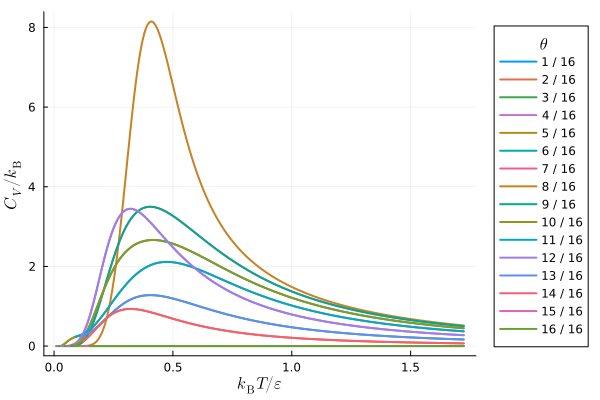

In [5]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read data from CSV file
Cv = CSV.read("data/Cv_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Create an empty plot with the legend positioned to the right
p = plot(xlabel="\$ k_{\\mathrm{B}} T / ε \$", 
         ylabel="\$ C_V / k_{\\mathrm{B}} \$", 
         size=(600, 400), 
         legendtitle="\$ \\theta \$",
         legend=:outerright)

# Loop over different numbers of occupied sites
for N in 1:L*M*length(square_basis)
    # Extract the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv))

    # Convert the temperatures to reduced units
    Ts = kB * df_N.T / abs(nn_energy)  # Ensure correct units for T and nn_energy

    # Extract the constant-volume heat capacity data
    Cv_N = df_N.Cv

    # Plot the constant-volume heat capacity as a function of temperature
    plot!(p, Ts, Cv_N, label="$(N) / $(L * M)", linewidth=2)
end

# Save the plot to a file
savefig(p, "figures/Cv_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.png")

# Display the plot
p

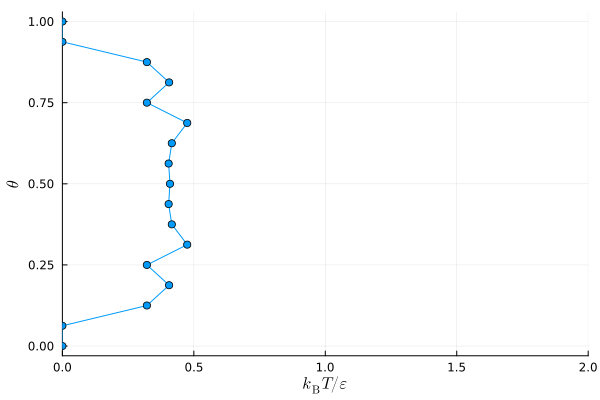

In [6]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read data
Cv_neighbor_list = CSV.read("data/Cv_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Create an empty DataFrame to store N and T_max
peak_df = DataFrame(N = Int[], T_max = Float64[])

# Loop over different numbers of occupied sites
push!(peak_df, (0, 0.0))
for N in 1:L*M*length(square_basis)
    # Filter the data for the current number of occupied sites and remove rows with NaN values in Cv column
    df_N = filter(row -> row.N == N && !isnan(row.Cv), Cv_neighbor_list)

    # Check if dataframe is empty
    if !isempty(df_N)
        # Find the index of the maximum heat capacity
        idx_max_Cv = argmax(df_N.Cv)
        
        # Find the temperature corresponding to the maximum heat capacity
        T_max = df_N.T[idx_max_Cv]
        
        # Append to the DataFrame
        if N == 1 || N == 15 || N == 16
            push!(peak_df, (N, 0.0))
        else
            push!(peak_df, (N, T_max))
        end
    end
end

# Save the DataFrame to a CSV file
CSV.write("data/peak_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", peak_df)

# Plotting
Trs = kB * peak_df.T_max ./ abs(nn_energy)
θs = peak_df.N ./ (L * M)
p = plot(Trs, θs, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel = "\$ \\theta \$", marker = :circle, legend = false, xlim=(0, 2))

# Save the plot to a file
savefig(p, "figures/peak_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.png")

# Display the plot
p

# Triangle Lattice

In [7]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for exact enumeration
L = triangular_supercell_dimensions[1]
M = triangular_supercell_dimensions[2]
adsorption_energy = -0.06
nn_energy = -0.01
nnn_energy = 0.00
cutoff_radii = (1.1, 1.5)
parameters = "exact_triangular_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"
microstates_file = "data/microstates_$parameters.csv"

# Perform exact enumeration if data files do not exist
if !isfile(cv_file) || !isfile(microstates_file)
    df_Cv = DataFrame(N = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[])
    df_microstates = DataFrame(N = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Any[])

    for N in 1:L*M*length(triangular_basis)
        # Perform exact enumeration
        energies, configurations = exact_enumeration(
            triangular_primitive_lattice_vectors,
            triangular_basis,
            triangular_supercell_dimensions,
            triangular_periodicity,
            N,
            triangular_adsorptions,
            adsorption_energy,
            nn_energy,
            nnn_energy,
            cutoff_radii
        )
        
        # Define temperature range and corresponding beta values
        Ts = collect(1.0:0.1:200.0)  # Temperatures in K
        βs = 1.0 ./ (kB * Ts)  # 1/eV
        
        # Prepare energy values for Cv calculation
        ωis = ones(length(energies))
        Eis = [ustrip(energy) for energy in energies]
        dof = 0
        
        # Calculate Cv for each temperature
        Cv_values = [cv(β, ωis, Eis, dof) / kB for β in βs]  # Cv in units of kB
        
        # Append Cv data to DataFrame
        append!(df_Cv, DataFrame(N = N, L = L, M = M, β = βs, T = Ts, Cv = Cv_values))
        
        # Append energy configurations data to DataFrame
        for i in 1:length(energies)
            append!(df_microstates, DataFrame(N = N, L = L, M = M, energy = energies[i], configurations = configurations[i]))
        end
    end
    
    # Write DataFrames to CSV files
    CSV.write(cv_file, df_Cv)
    CSV.write(microstates_file, df_microstates)
else
    println("Data files already exist. Skipping exact enumeration.")
end

Data files already exist. Skipping exact enumeration.


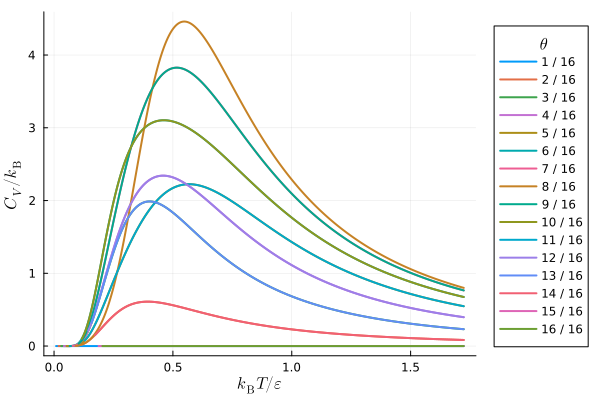

In [8]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read data
Cv = CSV.read("data/Cv_exact_triangular_L4_M2_adsorption-0.06_nn-0.01_nnn0.0_cutoff1.1_1.5.csv", DataFrame)

# Create an empty plot with the legend positioned to the right
p = plot(xlabel="\$ k_{\\mathrm{B}} T / ε \$", 
         ylabel="\$ C_V / k_{\\mathrm{B}} \$", 
         size=(600, 400), 
         legendtitle="\$ \\theta \$",
         legend=:outerright)

# Loop over different numbers of occupied sites
for N in 1:L*M*length(triangular_basis)
    # Extract the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv))

    # Convert the temperatures to reduced units
    Ts = kB * df_N.T / abs(nn_energy)  # Ensure correct units for T and nn_energy

    # Extract the constant-volume heat capacity data
    Cv_N = df_N.Cv

    # Plot the constant-volume heat capacity as a function of temperature
    plot!(p, Ts, Cv_N, label="$(N) / $(L * M * length(triangular_basis))", linewidth=2)
end

# Save the plot to a file
savefig(p, "figures/Cv_exact_triangular_L4_M2_adsorption-0.06_nn-0.01_nnn0.0_cutoff1.1_1.5.png")

# Display the plot
p

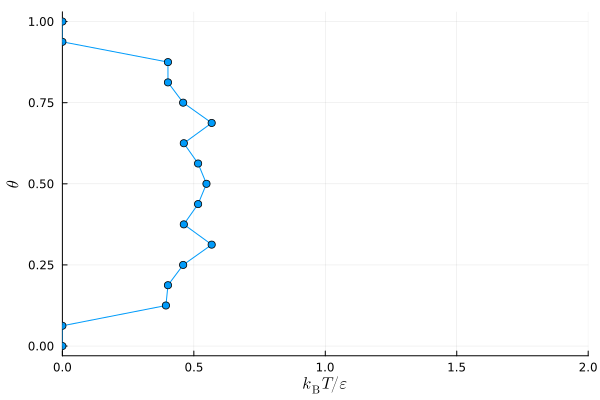

In [9]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read data
Cv_neighbor_list = CSV.read("data/Cv_exact_triangular_L4_M2_adsorption-0.06_nn-0.01_nnn0.0_cutoff1.1_1.5.csv", DataFrame)

# Create an empty DataFrame to store N and T_max
peak_df = DataFrame(N = Int[], T_max = Float64[])

# Loop over different numbers of occupied sites
push!(peak_df, (0, 0.0))
for N in 1:L*M*length(triangular_basis)
    # Filter the data for the current number of occupied sites and remove rows with NaN values in Cv column
    df_N = filter(row -> row.N == N && !isnan(row.Cv), Cv_neighbor_list)

    # Check if dataframe is empty
    if !isempty(df_N)
        # If N = 14, set T_max = T_max(N = 2)
        if N == 14
            df_N = filter(row -> row.N == 3 && !isnan(row.Cv), Cv_neighbor_list)
        end
        
        # Find the index of the maximum heat capacity
        idx_max_Cv = argmax(df_N.Cv)
        
        # Find the temperature corresponding to the maximum heat capacity
        T_max = df_N.T[idx_max_Cv]
        
        # Append to the DataFrame
        if N == 1 || N == 15 || N == 16
            push!(peak_df, (N, 0.0))
        else
            push!(peak_df, (N, T_max))
        end
    end
end

# Save the DataFrame to a CSV file
CSV.write("data/peak_exact_triangular_L4_M2_adsorption-0.06_nn-0.01_nnn0.0_cutoff1.1_1.5.csv", peak_df)

# Plotting
Trs = kB * peak_df.T_max ./ abs(nn_energy)
θs = peak_df.N ./ (L * M * length(triangular_basis))
p = plot(Trs, θs, xlabel="\$ k_{\\mathrm{B}} T / ε \$", ylabel = "\$ \\theta \$", marker = :circle, legend = false, xlim=(0, 2))

# Save the plot to a file
savefig(p, "figures/peak_exact_triangular_L4_M2_adsorption-0.06_nn-0.01_nnn0.0_cutoff1.1_1.5.png")

# Display the plot
display(p)